In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import json, pickle, gzip
from gensim.models import Word2Vec
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report

In [2]:
! nvidia-smi

Tue Oct  5 12:32:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   57C    P0    54W / 250W |    640MiB / 11018MiB |     35%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 37%   

In [3]:
post_id_2_text = pickle.load(open("../../data/non-graph/posts_id_2_text.pkl", "rb"))

In [4]:
post2user = pickle.load(open("../../data/non-graph/post_id_2_user_id.pkl", "rb"))
user2posts = pickle.load(open("../../data/non-graph/user_id_posts_idx_list.pkl", "rb"))
for post_id in tqdm(post2user):
    post_ids = set(user2posts[post2user[post_id]])
    post_ids.add(post_id)
    post2user[post_id] = sorted(list(post_ids))

100%|██████████| 10423/10423 [00:11<00:00, 891.42it/s] 


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from transformers import AutoTokenizer, AutoModel
model_name="bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(device)

cuda


In [6]:
class Classifier(nn.Module):
    
    def __init__(self, inp_dim, hid_dim, out_logits):
        super(Classifier, self).__init__()

        self.inp_dim = inp_dim
        self.out_dim = out_logits

        self.fc1 = nn.Linear(inp_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, out_logits)
    
    def forward(self, x):
        assert x.shape[1] == self.inp_dim

        x = self.fc1(x)
        x = self.fc2(torch.relu(x))
        return torch.log_softmax(x, dim=1)

In [7]:
def get_contrastive_batches(post_ids, device, batch_size):
    num_of_batches = post_ids.shape[0] // batch_size + (1 if post_ids.shape[0] % batch_size else 0)
    shuffled_idxs = np.random.permutation(np.arange(post_ids.shape[0]))
    for i in range(num_of_batches):
        batch_idxs = shuffled_idxs[i*batch_size:(i+1)*batch_size]
        X = np.zeros((batch_idxs.shape[0], 15, max_len), dtype=np.float32)
        for dim1, batch_idx in enumerate(batch_idxs):
            post_id = int(post_ids[batch_idx][:-4])
            user_id = post2user[post_id]
            positive_sample = post_id
            while positive_sample != post_id:
                positive_sample = np.random.choice(user2posts[user_id])
            batch_post_ids = [post_id, positive_sample]
            negative_user_ids = [userid for userid in user2posts if userid != user_id]
            negative_users = set()
            negative_samples = []
            while len(negative_users) < 8:
                negative_users.add(np.random.choice(negative_user_ids))
            for userid in list(negative_users):
                negative_samples.append(np.random.choice(user2posts[userid]))
            batch_post_ids.extend(negative_samples)
            for dim2, post_id in enumerate(batch_post_ids):
                text = post_id_2_text[post_id]
                ids = tokenizer(text, max_length=max_len, padding="max_length", truncation=True)['input_ids']
                X[dim1, dim2] = np.array(ids, dtype=int)
        yield torch.IntTensor(X).to(device)

In [8]:
def get_batches(post_ids, y, device, batch_size):
    num_of_batches = y.shape[0] // batch_size + (1 if y.shape[0] % batch_size else 0)
    shuffled_idxs = np.random.permutation(np.arange(y.shape[0]))
    for i in range(num_of_batches):
        batch_idxs = shuffled_idxs[i*batch_size:(i+1)*batch_size]
        X = np.zeros((batch_idxs.shape[0], 1, max_len), dtype=np.float32)
        for dim1, batch_idx in enumerate(batch_idxs):
            post_id = int(post_ids[batch_idx][:-4])
            batch_post_ids = [post_id]
            for dim2, post_id in enumerate(batch_post_ids):
                text = post_id_2_text[post_id]
                ids = tokenizer(text, max_length=max_len, padding="max_length", truncation=True)['input_ids']
                X[dim1, dim2] = np.array(ids, dtype=int)
        yield torch.IntTensor(X.squeeze()).to(device),\
                torch.LongTensor(y[batch_idxs]).to(device)

In [9]:
def contrastive_train(epoch_num, data, device, optimizer, criterion, enc, batch_size=32, verbose=False):
    print("Training | Epoch:", epoch_num)
    enc.train()
    losses = []
    for i, batch in enumerate(tqdm(get_contrastive_batches(data, device, batch_size),
                                    total=data.shape[0]//batch_size+(1 if data.shape[0]%batch_size else 0))):
        # given actual post
        out = enc(batch[:,0])['pooler_output']
        # given user level contrastive samples
        similarities2 = torch.zeros(batch.shape[0], 9).to(device)
        for j in range(1, 10):
            with torch.no_grad():
                out2 = enc(batch[:,j])['pooler_output']
            similarities2[:, j-1] = torch.mul(out, out2).sum(dim=1)
        loss = criterion(torch.log_softmax(similarities2, dim=1), torch.zeros(batch.shape[0], dtype=int).to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if verbose:
            print("Epoch:", epoch_num, "| Iter:", i+1, "| Loss:", round(loss.item(), 4))
    enc.eval()
    return losses

In [10]:
def label_finetune(epoch_num, data, labels, device, optimizers, criterion, enc, clf, batch_size=32, verbose=False):
    print("Training | Epoch:", epoch_num)
    enc.train()
    clf.train()
    losses = []
    for i, batch in enumerate(tqdm(get_batches(data, labels, device, batch_size),
                                    total=data.shape[0]//batch_size+(1 if data.shape[0]%batch_size else 0))):
        # given actual post
        out = enc(batch[0])['pooler_output']
        # given class labels
        out = clf(out)
        loss = criterion(out, batch[1])
        for optimizer in optimizers:
            optimizer.zero_grad()
        loss.backward()
        for optimizer in reversed(optimizers):
            optimizer.step()
        losses.append(loss.item())
        if verbose:
            print("Epoch:", epoch_num, "| Iter:", i+1, "| Loss:", round(loss.item(), 4))
    enc.eval()
    clf.eval()
    return losses

In [11]:
def evaluate(epoch_num, data, labels, device, enc, clf, batch_size=64):
    print("Evaluating | Epoch:", epoch_num)
    enc.eval()
    clf.eval()
    y_preds = []
    y_tests = []
    for batch in tqdm(get_batches(data, labels, device, batch_size),\
                                    total=data.shape[0]//batch_size+(1 if data.shape[0]%batch_size else 0)):
        with torch.no_grad():
            inp = enc(batch[0])['pooler_output']
            out = clf(inp)
        for y in batch[1].cpu().numpy():
            y_tests.append(y)
        for y in out.argmax(dim=1).cpu().numpy():
            y_preds.append(y)
    print(classification_report(y_tests, y_preds))

In [12]:
def get_ids_and_labels(split):
    ids = [i for i in pid[split] if 'gab' in i]
    labels = [label_dict[Counter([j["label"] for j in data[i]["annotators"]]).most_common(1)[0][0]] for i in pid[split] if 'gab' in i]
    return np.array(ids), np.array(labels)

In [13]:
data_path = '../../data/commons/dataset.json'
pid_path = '../../data/commons/post_id_divisions.json'

with open(pid_path) as f:
    pid = json.load(f)
with open(data_path) as f:
    data = json.load(f)

label_dict = {'normal': 0, 'offensive': 1, 'hatespeech': 2}

train_ids, train_labels = get_ids_and_labels("train")
val_ids, val_labels = get_ids_and_labels("val")
test_ids, test_labels = get_ids_and_labels("test")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training | Epoch: 1


100%|██████████| 262/262 [05:10<00:00,  1.18s/it]


Training | Epoch: 2


100%|██████████| 262/262 [05:09<00:00,  1.18s/it]


Training | Epoch: 3


100%|██████████| 262/262 [05:09<00:00,  1.18s/it]


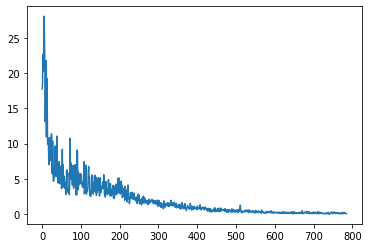

In [14]:
# max_len = 128
# encoder = AutoModel.from_pretrained(model_name).to(device)
# classifier = Classifier(768, 128, 3).to(device)
# optimizer1 = optim.Adam(encoder.parameters(), lr=1e-5)
# criterion = nn.NLLLoss()
# aux_losses = []
for i in range(3):
    aux_losses.extend(contrastive_train(i+1, train_ids, device, optimizer1, criterion, encoder, 32))
plt.plot(aux_losses)
plt.show()

Training | Epoch: 1


100%|██████████| 262/262 [01:08<00:00,  3.81it/s]


Evaluating | Epoch: 1


100%|██████████| 33/33 [00:02<00:00, 11.31it/s]

              precision    recall  f1-score   support

           0       0.56      0.63      0.59       216
           1       0.56      0.39      0.46       305
           2       0.75      0.84      0.79       515

    accuracy                           0.66      1036
   macro avg       0.62      0.62      0.61      1036
weighted avg       0.65      0.66      0.65      1036



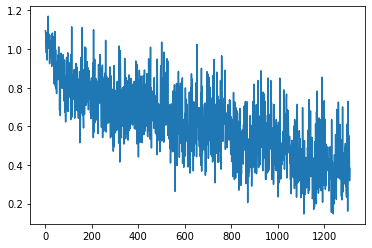

In [20]:
# optimizer1 = optim.Adam(encoder.parameters(), lr=1e-5)
# optimizer2 = optim.Adam(classifier.parameters(), lr=1e-4)
# optimizers = [optimizer1, optimizer2]
# losses = []
for i in range(1):
    losses.extend(label_finetune(i+1, train_ids, train_labels, device, optimizers, criterion, encoder, classifier, 32))
    evaluate(i+1, test_ids, test_labels, device, encoder, classifier, batch_size=32)
plt.plot(losses)
plt.show()

In [16]:
# torch.save(encoder.state_dict(), "encoder_bert_user.pth")
# torch.save(classifier.state_dict(), "classifier_bert_user.pth")

In [17]:
# evaluate(i+1, test_ids, test_labels, device, encoder, classifier, batch_size=32)